In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tabulate import tabulate
from IPython.display import display, HTML
from google.colab import files
import io

In [2]:
def upload_df(dataset_name):

    uploaded = files.upload()
    df = pd.read_csv(io.BytesIO(uploaded[dataset_name]))
    try: 
        df.drop('Unnamed: 0', axis=1, inplace=True)
    except:
        pass
    display(HTML(df.head().to_html()))
    return df

In [3]:
def save_df(df, file_name):

    df.to_csv(file_name)
    files.download(file_name)

In [4]:
def add_columns(df):

    # Add 'DayDiff' column - The difference between Snapshot Date and Checkin Date.
    df[['Checkin Date','Snapshot Date']] = df[['Checkin Date','Snapshot Date']].apply(pd.to_datetime)
    df['DayDiff'] = (df['Checkin Date'] - df['Snapshot Date']).dt.days
    # Add 'WeekDay' column - The day name of the Checkin Date.
    df['WeekDay'] = df['Checkin Date'].dt.day_name()
    # Add the 'DiscountDiff' column - The difference between 'Original Price' and 'Discount Price'.
    df['DiscountDiff'] = df['Original Price'] - df['Discount Price']
    # Add the 'DiscountPerc' column - Percentage discount between the 'Original Price' and the 'Discount Price'
    df['DiscountPerc'] = 100 - ((df['Discount Price'] / df['Original Price']) * 100)
    display(HTML(df.head().to_html()))

In [5]:
class DataCleaner:

    def __init__(self, df):
        self.df = df
        self.to_drop = ['Discount Code','Snapshot Date','Hotel Name','WeekDay', 'Days', 'Snapshot ID', 'Hotel Stars',
                        'Available Rooms', 'DayDiff']
        self.flierprops = dict(marker='*',markerfacecolor='blue',markersize=9,linestyle='none')

    def show_statistics(self):
        display(HTML(self.df.describe().to_html()))


    def plt_boxplot(self):
        self.df.drop(self.to_drop, axis=1).plot(kind='box', flierprops=self.flierprops, subplots=True, layout=(2,3), figsize=(15,10), title='BoxPlot - hotels data')
        plt.show()
    
    def plt_scatter_matrix(self):
        pd.plotting.scatter_matrix(self.df.drop(self.to_drop, axis=1), figsize=(15,10),diagonal='kde',  color='red')
        plt.show()

    def normalize(self):
        self.df['Discount Price'] = np.log(self.df['Discount Price'])
        self.df['DiscountPerc'] = np.log(self.df['DiscountPerc'])
        self.df['DiscountDiff'] = np.log(self.df['DiscountDiff'])

    def clean_outliers(self):
        all_outliers = np.array([], dtype = 'int64')
        for feature in ['DiscountPerc', 'DiscountDiff', 'Discount Price']:
            Q1 = np.percentile(self.df[feature], 25)
            Q3 = np.percentile(self.df[feature], 75)
            step = 2.0 * (Q3 - Q1)
            outlier_pts = self.df[~((self.df[feature] >= Q1 - step) & (self.df[feature] <= Q3 + step))]
            all_outliers = np.append(all_outliers,outlier_pts.index.values.astype('int64'))
        # drop outliers rows.
        all_outliers, indices = np.unique(all_outliers, return_inverse=True)
        counts = np.bincount(indices)
        outliers = all_outliers[counts > 0]
        self.df = self.df.drop(self.df.index[outliers]).reset_index(drop=True)
        print('[INFO] The len after deleteing outliers:', len(self.df))

    def get_df(self):
        return self.df

In [6]:
# upload dataset
df = upload_df('hotels_data.csv')

Saving hotels_data.csv to hotels_data.csv


,Snapshot ID,Snapshot Date,Checkin Date,Days,Original Price,Discount Price,Discount Code,Available Rooms,Hotel Name,Hotel Stars
0,1,7/17/2015 0:00,8/12/2015 0:00,5,1178,1040,1,6,Best Western Plus Seaport Inn Downtown,3
1,1,7/17/2015 0:00,8/19/2015 0:00,5,1113,982,1,8,Best Western Plus Seaport Inn Downtown,3
2,1,7/17/2015 0:00,8/13/2015 0:00,5,4370,4240,1,3,The Peninsula New York,5
3,1,7/17/2015 0:00,7/26/2015 0:00,5,1739,1667,1,18,Eventi Hotel a Kimpton Hotel,4
4,1,7/17/2015 0:00,8/12/2015 0:00,5,1739,1672,1,3,Eventi Hotel a Kimpton Hotel,4


In [7]:
# add columns
add_columns(df)

,Snapshot ID,Snapshot Date,Checkin Date,Days,Original Price,Discount Price,Discount Code,Available Rooms,Hotel Name,Hotel Stars,DayDiff,WeekDay,DiscountDiff,DiscountPerc
0,1,2015-07-17,2015-08-12,5,1178,1040,1,6,Best Western Plus Seaport Inn Downtown,3,26,Wednesday,138,11.714771
1,1,2015-07-17,2015-08-19,5,1113,982,1,8,Best Western Plus Seaport Inn Downtown,3,33,Wednesday,131,11.769991
2,1,2015-07-17,2015-08-13,5,4370,4240,1,3,The Peninsula New York,5,27,Thursday,130,2.974828
3,1,2015-07-17,2015-07-26,5,1739,1667,1,18,Eventi Hotel a Kimpton Hotel,4,9,Sunday,72,4.140311
4,1,2015-07-17,2015-08-12,5,1739,1672,1,3,Eventi Hotel a Kimpton Hotel,4,26,Wednesday,67,3.852789


In [10]:
# save
save_df(df, 'Hotels_data_Changed.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
# upload the new dataset
df = upload_df('Hotels_data_Changed.csv')

Saving Hotels_data_Changed.csv to Hotels_data_Changed (1).csv


,Snapshot ID,Snapshot Date,Checkin Date,Days,Original Price,Discount Price,Discount Code,Available Rooms,Hotel Name,Hotel Stars,DayDiff,WeekDay,DiscountDiff,DiscountPerc
0,1,2015-07-17,2015-08-12,5,1178,1040,1,6,Best Western Plus Seaport Inn Downtown,3,26,Wednesday,138,11.714771
1,1,2015-07-17,2015-08-19,5,1113,982,1,8,Best Western Plus Seaport Inn Downtown,3,33,Wednesday,131,11.769991
2,1,2015-07-17,2015-08-13,5,4370,4240,1,3,The Peninsula New York,5,27,Thursday,130,2.974828
3,1,2015-07-17,2015-07-26,5,1739,1667,1,18,Eventi Hotel a Kimpton Hotel,4,9,Sunday,72,4.140311
4,1,2015-07-17,2015-08-12,5,1739,1672,1,3,Eventi Hotel a Kimpton Hotel,4,26,Wednesday,67,3.852789


In [12]:
# let's see how the data look statistically
data_cleaner = DataCleaner(df)
data_cleaner.show_statistics()

,Snapshot ID,Days,Original Price,Discount Price,Discount Code,Available Rooms,Hotel Stars,DayDiff,DiscountDiff,DiscountPerc
count,187848.000000,187848.0,187848.000000,187848.000000,187848.000000,187848.000000,187848.000000,187848.000000,187848.000000,187848.000000
mean,351.643451,5.0,1825.742143,1673.172283,2.434186,14.588561,3.905823,17.465685,152.569860,8.877715
std,1007.348927,0.0,1042.355712,983.618013,1.005191,41.575482,0.846496,10.040225,143.316985,6.030248
min,1.000000,5.0,289.000000,260.000000,1.000000,-1.000000,0.000000,1.000000,15.000000,0.581395
25%,150.000000,5.0,1160.000000,1035.000000,2.000000,-1.000000,3.000000,9.000000,70.000000,4.844961
50%,439.000000,5.0,1599.000000,1475.000000,2.000000,-1.000000,4.000000,18.000000,103.000000,7.056229
75%,506.000000,5.0,2160.000000,1963.250000,3.000000,8.000000,4.000000,26.000000,180.000000,10.933941
max,417419.000000,5.0,29975.000000,28675.000000,4.000000,431.000000,5.000000,34.000000,3760.000000,68.425842


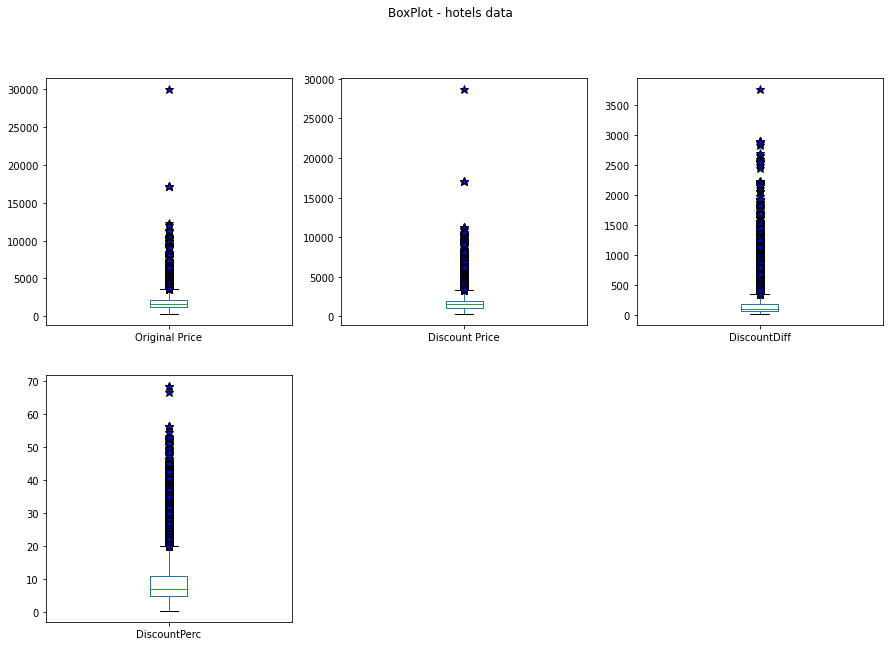

In [13]:
# here is a Boxplot that will provide a better understanding of data distribution
data_cleaner.plt_boxplot()
# Discount Diff, Discount Perc, Discount Price do not have a normal distribution, and they all have outliers

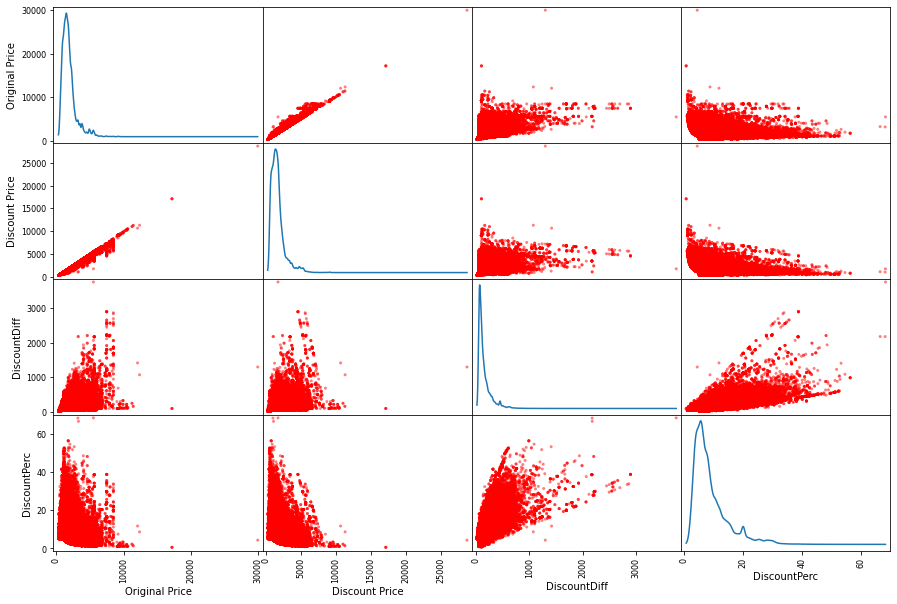

In [14]:
# the distribution of the interesting features can be seen in the following figure
data_cleaner.plt_scatter_matrix()

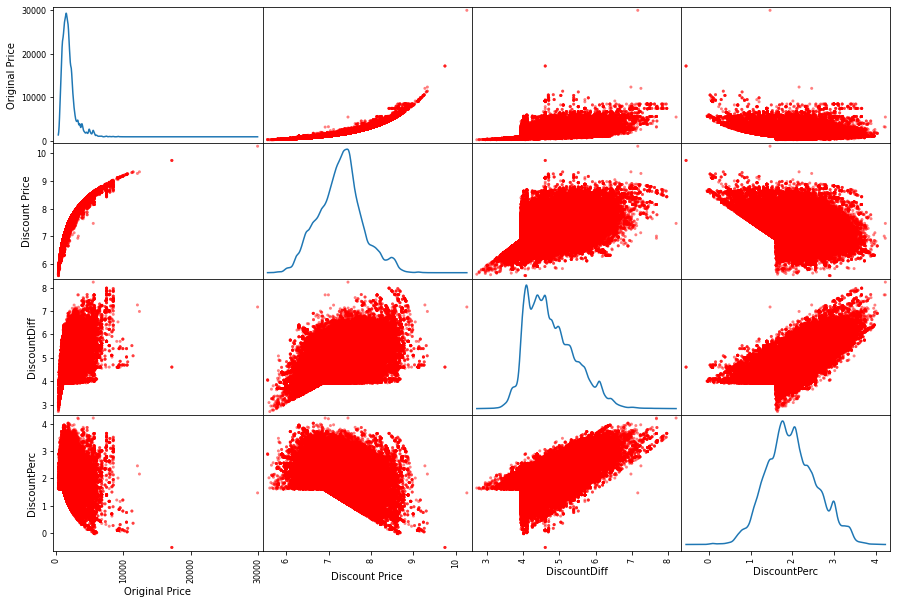

In [15]:
# the next step will be to normalize the problematic features and see what the result will be
data_cleaner.normalize()
data_cleaner.plt_scatter_matrix()

In [16]:
# once a row contains 3 outliers, it will be deleted
data_cleaner.clean_outliers()

[INFO] The len after deleteing outliers: 187218


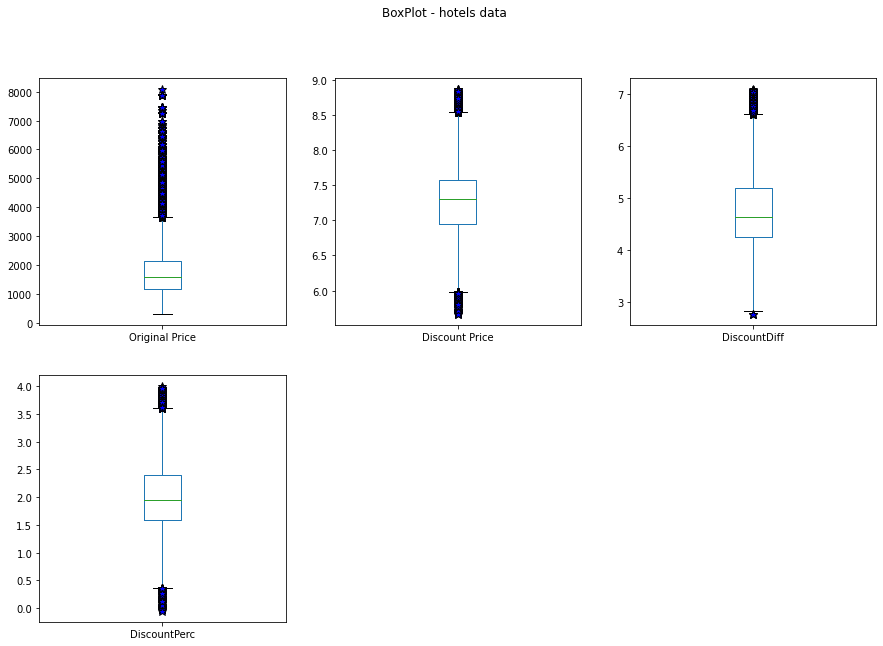

In [17]:
# let's see the impact of the change
data_cleaner.plt_boxplot()

In [18]:
# save the cleaned dataset
save_df(data_cleaner.get_df(), 'Hotels_data_cleaned.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>